In [4]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix


# For CF engines
import sys
PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)
from src.cf_engines import predict_ratings_user_cf, predict_ratings_item_cf

# Paths
PROCESSED_DIR = "../data/processed"
ratings_file = os.path.join(PROCESSED_DIR, "ratings_processed.csv")
movies_file = os.path.join(PROCESSED_DIR, "movies_processed.csv")
sparse_file = os.path.join(PROCESSED_DIR, "user_item_matrix.pkl")


In [5]:
ratings = pd.read_csv(ratings_file)
movies = pd.read_csv(movies_file)

with open(sparse_file, "rb") as f:
    user_item_matrix = pickle.load(f)

n_users, n_items = user_item_matrix.shape
print(f"Sparse matrix shape: {user_item_matrix.shape}")


Sparse matrix shape: (943, 1682)


In [6]:
# For explicit feedback, leave one rating per user for testing
train_matrix = user_item_matrix.copy()
test_matrix = np.zeros_like(user_item_matrix.toarray())

for user_idx in range(n_users):
    rated_items = user_item_matrix[user_idx].indices
    if len(rated_items) == 0:
        continue
    test_item = np.random.choice(rated_items)
    test_matrix[user_idx, test_item] = user_item_matrix[user_idx, test_item]
    train_matrix[user_idx, test_item] = 0

train_matrix = csr_matrix(train_matrix)
test_matrix = csr_matrix(test_matrix)


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# User-based similarity
user_sim_matrix = cosine_similarity(train_matrix)

# Item-based similarity
item_sim_matrix = cosine_similarity(train_matrix.T)


In [8]:
def precision_at_k(recommended, relevant, k=10):
    recommended = recommended[:k]
    return len(set(recommended) & set(relevant)) / k

def recall_at_k(recommended, relevant, k=10):
    recommended = recommended[:k]
    return len(set(recommended) & set(relevant)) / len(relevant) if len(relevant) > 0 else 0

def evaluate_model(model_type, top_n=10, k=5):
    precisions, recalls = [], []
    
    for user_idx in range(n_users):
        # Get relevant items from test set
        relevant_items = test_matrix[user_idx].indices
        
        if len(relevant_items) == 0:
            continue
        
        if model_type == "user_cf":
            recs = predict_ratings_user_cf(user_idx, train_matrix, user_sim_matrix, movies, top_n=top_n, k=k)
        elif model_type == "item_cf":
            recs = predict_ratings_item_cf(user_idx, train_matrix, item_sim_matrix, movies, top_n=top_n, k=k)
        elif model_type == "popularity":
            top_movies = ratings.groupby("movie_idx")["rating"].count().sort_values(ascending=False).index[:top_n]
            recs = movies[movies["movie_idx"].isin(top_movies)]
        else:
            raise ValueError("Unknown model_type")
        
        recommended_items = recs["movie_idx"].tolist()
        precisions.append(precision_at_k(recommended_items, relevant_items, k=top_n))
        recalls.append(recall_at_k(recommended_items, relevant_items, k=top_n))
    
    return np.mean(precisions), np.mean(recalls)


In [9]:
top_n = 10
k_neighbors = 5

metrics = {}
for model in ["popularity", "user_cf", "item_cf"]:
    prec, rec = evaluate_model(model, top_n=top_n, k=k_neighbors)
    metrics[model] = {"Precision@10": prec, "Recall@10": rec}

metrics_df = pd.DataFrame(metrics).T
metrics_df


,Precision@10,Recall@10
popularity,0.007105,0.071050
user_cf,0.024920,0.249205
item_cf,0.003287,0.032874


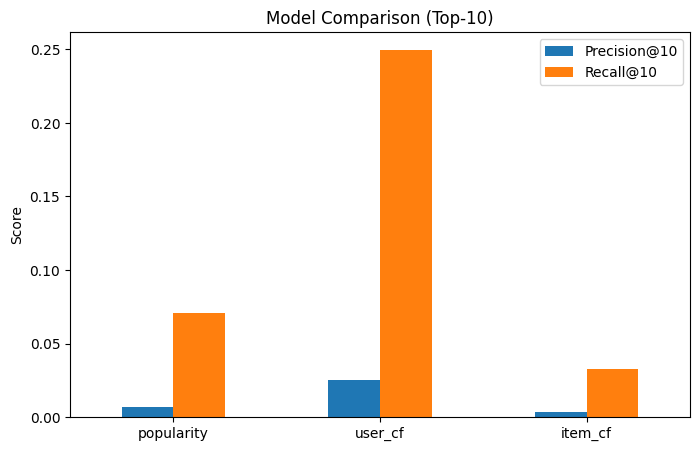

In [10]:
import matplotlib.pyplot as plt

metrics_df.plot(kind="bar", figsize=(8,5), rot=0)
plt.title(f"Model Comparison (Top-{top_n})")
plt.ylabel("Score")
plt.show()


User CF is clearly the best baseline for this dataset

Popularity can be used as a fallback for cold-start users

Item CF in this small dataset doesn’t perform well, but could improve with larger datasets like ML-1M or ML-20M